In [6]:
TOT_TRANSACTIONS= 1000;
NUM_USERS = 100;

In [7]:
import json
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import time
from web3 import Web3


In [8]:
# Connect to local Ethereum node
w3 = Web3(Web3.HTTPProvider('http://127.0.0.1:8545'))
w3.eth.default_account = w3.eth.accounts[0]

# Load contract address and ABI
with open('contract_address.txt', 'r') as file:
    contract_address = file.read()

with open('contract_abi.json', 'r') as file:
    abi = json.load(file)

# Create contract instance
contract = w3.eth.contract(address=contract_address, abi=abi)

# Start overall timer
overall_start = time.time()

In [9]:


# Step 1: Generate a Connected Network
network_start = time.time()
num_users = NUM_USERS
G = nx.connected_watts_strogatz_graph(n=num_users, k=4, p=0.5, tries=100)
if not nx.is_connected(G):
    print("Generated graph is not connected.")
    G = nx.connected_watts_strogatz_graph(n=num_users, k=4, p=0.5, tries=100)
network_end = time.time()
print(f"Network generation time: {network_end - network_start:.2f} seconds")

Network generation time: 0.00 seconds


In [10]:
# Step 2: Register Users
registration_start = time.time()
for node in G.nodes():
    tx = contract.functions.registerUser(node, f"User{node}").transact()
    w3.eth.wait_for_transaction_receipt(tx)
registration_end = time.time()
print(f"User registration time: {registration_end - registration_start:.2f} seconds")

User registration time: 74.01 seconds


In [11]:
# Step 3: Create Joint Accounts
account_start = time.time()
edge_list = list(G.edges())
balances = np.random.exponential(scale=10, size=len(edge_list))
print("Creating joint accounts...")
for i, (u1, u2) in enumerate(edge_list):
    initial_contribution = max(int(balances[i] / 2), 1)  # Ensure at least 1
    tx = contract.functions.createAcc(u1, u2, initial_contribution).transact()
    w3.eth.wait_for_transaction_receipt(tx)
print("All joint accounts created.")
account_end = time.time()
print(f"Account creation time: {account_end - account_start:.2f} seconds")

Creating joint accounts...
All joint accounts created.
Account creation time: 251.39 seconds


In [12]:
# Step 4: Simulate Transactions
transaction_start = time.time()
success_count = 0
total_transactions = 0
success_ratios = []

print("Simulating transactions...")
for i in range(TOT_TRANSACTIONS):
    sender = random.choice(list(G.nodes()))
    receiver = random.choice(list(G.nodes()))
    while receiver == sender:
        receiver = random.choice(list(G.nodes()))

    amount = 1  # Unit amount

    # Perform pathfinding off-chain
    try:
        path = nx.shortest_path(G, source=sender, target=receiver)
    except nx.NetworkXNoPath:
        path = []

    if path:
        # Send transaction
        try:
            tx = contract.functions.sendAmount(sender, receiver, amount, path).transact({'gas': 3000000})
            w3.eth.wait_for_transaction_receipt(tx)
            success_count += 1
        except Exception as e:
            print(f"Transaction from User{sender} to User{receiver} failed: {e}")
    else:
        print(f"No path found between User{sender} and User{receiver}")
    total_transactions += 1

    if (i + 1) % 10 == 0:
        success_ratio = success_count / total_transactions
        success_ratios.append(success_ratio)
        print(f"After {total_transactions} transactions, success ratio: {success_ratio:.2f}")

transaction_end = time.time()
print(f"Transaction simulation time: {transaction_end - transaction_start:.2f} seconds")



Simulating transactions...
Transaction from User50 to User34 failed: The response was in an unexpected format and unable to be parsed. Response cannot include both "error" and "result". The raw response is: {'id': 2723, 'jsonrpc': '2.0', 'result': '0x2dc3d7727024da4d60592e272f88b5e343975b61eb1f49649b2c3b1f0723b6ee', 'error': {'message': 'VM Exception while processing transaction: revert Insufficient balance in account', 'code': -32000, 'data': {'0x2dc3d7727024da4d60592e272f88b5e343975b61eb1f49649b2c3b1f0723b6ee': {'error': 'revert', 'program_counter': 2638, 'return': '0x08c379a00000000000000000000000000000000000000000000000000000000000000020000000000000000000000000000000000000000000000000000000000000001f496e73756666696369656e742062616c616e636520696e206163636f756e7400', 'reason': 'Insufficient balance in account'}, 'stack': 'c: VM Exception while processing transaction: revert Insufficient balance in account\n    at Function.c.fromResults (C:\\Users\\navne\\AppData\\Roaming\\npm\\node_m

[0.9, 0.9, 0.9, 0.825, 0.82, 0.8166666666666667, 0.7714285714285715, 0.7625, 0.7555555555555555, 0.72, 0.7272727272727273, 0.7333333333333333, 0.7307692307692307, 0.7285714285714285, 0.7266666666666667, 0.725, 0.7176470588235294, 0.7277777777777777, 0.7315789473684211, 0.725, 0.7238095238095238, 0.7181818181818181, 0.7130434782608696, 0.7083333333333334, 0.704, 0.6884615384615385, 0.6851851851851852, 0.6785714285714286, 0.6862068965517242, 0.69, 0.6838709677419355, 0.684375, 0.6848484848484848, 0.6823529411764706, 0.6742857142857143, 0.675, 0.6756756756756757, 0.6736842105263158, 0.6692307692307692, 0.6675, 0.6634146341463415, 0.6595238095238095, 0.6581395348837209, 0.6568181818181819, 0.6533333333333333, 0.6478260869565218, 0.6446808510638298, 0.6395833333333333, 0.636734693877551, 0.634, 0.6313725490196078, 0.6326923076923077, 0.6283018867924528, 0.6259259259259259, 0.6236363636363637, 0.6232142857142857, 0.6210526315789474, 0.6241379310344828, 0.6203389830508474, 0.62, 0.61803278688

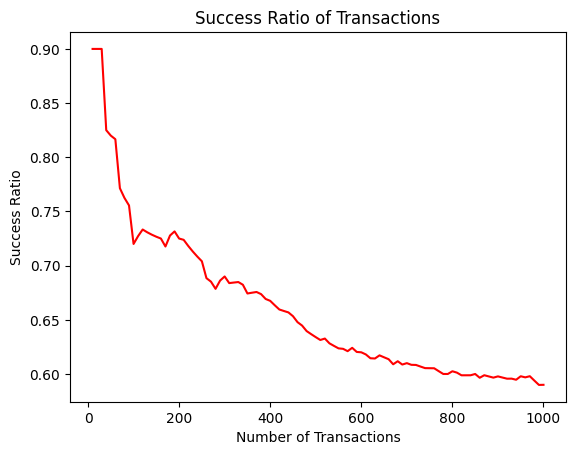

In [23]:
print(success_ratios)

# Plot success ratios
plt.plot(range(10, TOT_TRANSACTIONS + 1, 10), success_ratios, color='r')
plt.xlabel("Number of Transactions")
plt.ylabel("Success Ratio")
plt.title("Success Ratio of Transactions")
plt.show()


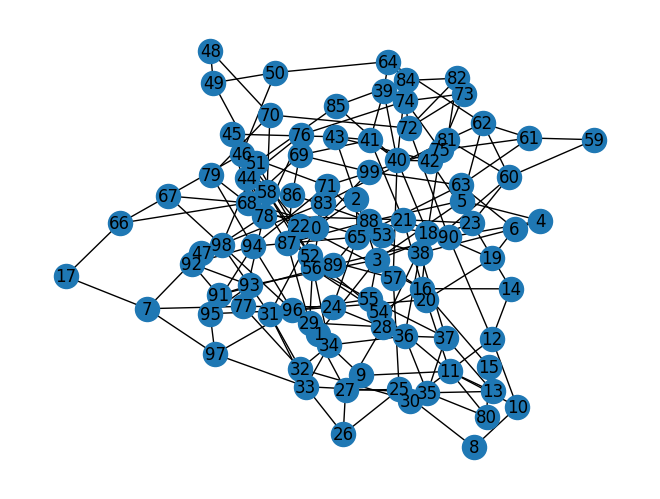

In [16]:
# visualize the network
nx.draw(G, with_labels=True)
plt.show()
